# Keras-based GAN for MNIST

In [ ]:
! pip install tensorflow

LATENT_DIM stands for latent dimension — it defines the size of the input noise vector fed into the generator of a GAN

In [ ]:
"""
Keras-based GAN for MNIST
-------------------------
This script shows a minimal example of how to train a GAN on the MNIST dataset
using TensorFlow and Keras. It defines a Generator, a Discriminator, and a
custom "GAN" model that implements a training step combining both networks.
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt


# Hyperparameters
LATENT_DIM = 100
EPOCHS = 30
BATCH_SIZE = 64

# Directory to save generated images
os.makedirs("gan_samples", exist_ok=True)

https://keras.io/api/models/sequential/#sequential-class

### Build the generator model using Keras Sequential API

1. First dense layer to project and reshape.  
    - change any latent vector dimension to a tensor 3 dimensional shape.  
    - (7, 7, 256) which will be upsampled to (28, 28, 1).  
    - The first layer will output a tensor of shape (7, 7, 256).  
    - This is the first step in the upsampling process.  
    - The input shape is (LATENT_DIM,) which is a 1D vector.  
    - The output shape will be (7, 7, 256) after reshaping.  
        + 256 is the input channels.  

2. BatchNormalization is a layer in Keras that normalizes the activations of the previous layer per mini-batch. It helps the network train faster and generalize better.  

3. Why use LeakyReLU() in a GAN Generator (LeakyReLU stands for Leaky Rectified Linear Unit)?  Activation that avoids zero-gradient.   
- Prevent dead neurons.  
- Maintain gradient flow even with negative values.  
- Stabilize training.  
By default, alpha=0.3

➡️ Conv2D makes images smaller,   
➡️ Conv2DTranspose makes them larger.

    + 128 is the number of filters (output channels).  
    + 5x5 is the filter size applied to each input region.  
    Input Size (H, W) and Kernel (Kh, Kw).   
padding = floor(kernel_size / 2) = 2.  
Output size=(Input size−1)×stride+kernel size−2×padding = (7−1)×1+5−2×2 =7 (because stride = 1 padding = 'same')

| Layer           | Spatial Size  | Filters (Channels) | Purpose                      |
| --------------- | ------------- | ------------------ | ---------------------------- |
| Dense + Reshape | `(7, 7)`      | 256 or 512         | Start from latent vector     |
| Conv2DTranspose | `(14, 14)`    | 128                | Learn mid-level features     |
| Conv2DTranspose | `(28, 28)`    | 64                 | Learn texture, edges         |
| Conv2DTranspose | `(28, 28, 1)` | 1 or 3             | Final image: grayscale pixel |




In [ ]:
def build_generator():
    """
    Build the generator model using Keras Sequential API.
    The generator takes a latent vector of shape (LATENT_DIM,)
    and outputs a (28, 28, 1) image.
    """
    model = keras.Sequential(name="Generator")

    # First layer: Dense layer to reshape the latent vector
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization()) # Normalize the output
    model.add(layers.LeakyReLU()) # Activation function for non-linearity

    model.add(layers.Reshape((7, 7, 256)))  # Output shape: (7, 7, 256)

    # Upsample to (14, 14, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))  # Output: (14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # Output: (14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final upsample to (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))  # Output: (28, 28, 1)

    return model



### Build the discriminator model using Keras Sequential API

| Layer                        | Output Shape   | Purpose                              |
| ---------------------------- | -------------- | ------------------------------------ |
| `Conv2D(64, 5x5, stride=2)`  | `(14, 14, 64)` | Extract low-level features           |
| `LeakyReLU`, `Dropout(0.3)`  | `(14, 14, 64)` | Add non-linearity and regularization |
| `Conv2D(128, 5x5, stride=2)` | `(7, 7, 128)`  | Learn deeper features                |
| `Flatten()`                  | `(6272,)`      | Convert 3D feature map to 1D         |
| `Dense(1)`                   | `(1,)`         | Output real/fake score (logit)       |


In [ ]:
def build_discriminator():
    """
    Build the discriminator model using Keras Sequential API.
    The discriminator takes a (28, 28, 1) image and outputs a single scalar (real or fake).
    """
    model = keras.Sequential(name="Discriminator")

    # Input: (28, 28, 1)
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Output: (14, 14, 64)
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Output: (7, 7, 128)
    model.add(layers.Flatten())           # Shape: (7*7*128,)
    model.add(layers.Dense(1))            # Output: scalar (logit)

    return model


### Train the GAN

In [ ]:
class GAN(keras.Model):
    """
    A custom Keras Model that contains both the generator and discriminator.
    The `train_step()` method overrides the default .fit() logic, combining
    the training of the discriminator and generator in one step.
    """
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, real_images):
        """
        Perform one training step:
          1) Train discriminator on real images and fake images
          2) Train generator to fool the discriminator
        """
        batch_size = tf.shape(real_images)[0]

        # ----------------------
        # Train Discriminator
        # ----------------------
        # Sample random noise to generate fake images
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
        fake_images = self.generator(random_latent_vectors)

        # Labels for real (1) and fake (0) images
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train on real and fake images
        with tf.GradientTape() as tape:
            # Predictions for real images
            real_preds = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(real_labels, real_preds)

            # Predictions for fake images
            fake_preds = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(fake_labels, fake_preds)

            # Combine discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # ----------------------
        # Train Generator
        # ----------------------
        # Generate new random noise
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
        with tf.GradientTape() as tape:
            # The generator wants the discriminator to think these are real!
            fake_images = self.generator(random_latent_vectors, training=True)
            preds = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(real_labels, preds)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

### Download and load the MNIST dataset.

In [ ]:
def prepare_mnist_dataset(batch_size=64):
    """
    Load MNIST data
    """
    # TODO: Complete
    (x_train, _), (_, _) = keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0  # Normalize to [0, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension (28, 28, 1)
    x_train = (x_train - 0.5) * 2.0  # Scale to [-1, 1] for GAN training
    dataset = tf.data.Dataset.from_tensor_slices(x_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

### Utils

In [ ]:
def save_samples(generator, epoch, n=16, sample_dir="gan_samples"):
    """
    Save a grid of generated images (n x n images total).
    """
    random_latent_vectors = tf.random.normal(shape=(n, LATENT_DIM))
    generated = generator(random_latent_vectors, training=False)
    generated = (generated * 127.5 + 127.5).numpy().astype(np.uint8)  # denormalize from [-1,1] to [0,255]

    # Create a tiled image for easy viewing
    rows, cols = 4, 4  # for 16 images
    tiled_image = np.zeros((28 * rows, 28 * cols), dtype=np.uint8)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            img = generated[idx, :, :, 0]
            tiled_image[i*28:(i+1)*28, j*28:(j+1)*28] = img
            idx += 1

    # Save the grid to a PNG
    save_path = os.path.join(sample_dir, f"epoch_{epoch:03d}.png")
    from PIL import Image
    Image.fromarray(tiled_image).save(save_path)
    print(f"Saved sample images to {save_path}")


In [ ]:
class LossPlotCallback(keras.callbacks.Callback):
    """
    Callback that stores the loss each epoch and plots them at the end of training.
    """
    def on_train_begin(self, logs=None):
        self.d_losses = []
        self.g_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # logs: Dictionary of metrics for this epoch, including d_loss & g_loss
        self.d_losses.append(logs.get("d_loss"))
        self.g_losses.append(logs.get("g_loss"))

    def on_train_end(self, logs=None):
        # Plot the stored losses after all epochs finish
        epochs_range = range(1, len(self.d_losses) + 1)
        plt.figure(figsize=(8,5))
        plt.plot(epochs_range, self.d_losses, label="Discriminator Loss")
        plt.plot(epochs_range, self.g_losses, label="Generator Loss")
        plt.title("GAN Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig("loss_plot.png")
        plt.show()


### Main

In [ ]:
def main():
    # Prepare dataset
    dataset = prepare_mnist_dataset(batch_size=BATCH_SIZE)

    # Build models
    generator = build_generator()
    discriminator = build_discriminator()

    # Instantiate the GAN
    gan = GAN(generator=generator, discriminator=discriminator)

    # Compile it with Adam optimizers for G and D
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=False)
    )

    # Keras Callback to save images after each epoch
    class SampleCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            save_samples(self.model.generator, epoch+1)

    # Train!
    gan.fit(dataset, epochs=EPOCHS, callbacks=[SampleCallback(), LossPlotCallback()])

    print("Training complete! Check the 'gan_samples' folder for generated images.")
    print("A plot of loss per epoch has been saved as 'loss_plot.png'.")



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.0218 - g_loss: 10.7874Saved sample images to gan_samples/epoch_001.png
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - d_loss: 0.0217 - g_loss: 10.7930
Epoch 2/30
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 6.5889e-06 - g_loss: 16.1181Saved sample images to gan_samples/epoch_002.png
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 6.5613e-06 - g_loss: 16.1181
Epoch 3/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.5575e-06 - g_loss: 16.1181Saved sample images to gan_samples/epoch_003.png
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.5544e-06 - g_loss: 16.1181
Epoch 4/30
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.0580e-06 - g_loss: 16.1181Saved sample images to gan_samples/epoch_004.png
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.0550e-06 - g_loss: 16.1181
Epoch 5/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.5301e-06 - g_loss: 16.1181Saved sample images to gan_samples/epoch

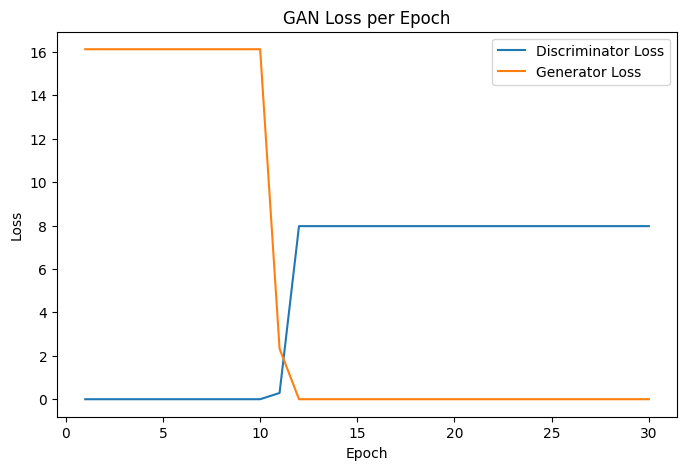

Training complete! Check the 'gan_samples' folder for generated images.
A plot of loss per epoch has been saved as 'loss_plot.png'.


In [ ]:

if __name__ == "__main__":
    main()
